In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

2025-05-18 12:24:29.492346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747571069.747555      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747571069.823029      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set Parameters

In [2]:
dataset_path = "/kaggle/input/garbage-classification-v2/garbage-dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ['battery','biological','cardboard','clothes', 'glass', 'metal', 'paper', 'plastic','shoes', 'trash']

# Data Loading + Augmentation

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


# Build Model Using MobileNetV2

In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-18 12:24:57.513280: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#  Train the Model

In [5]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=12
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 642s 1s/step - accuracy: 0.7205 - loss: 0.8898 - val_accuracy: 0.8868 - val_loss: 0.3509
Epoch 2/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.8889 - loss: 0.3369 - val_accuracy: 0.9000 - val_loss: 0.3074
Epoch 3/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.9025 - loss: 0.2927 - val_accuracy: 0.9028 - val_loss: 0.3009
Epoch 4/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - accuracy: 0.9090 - loss: 0.2731 - val_accuracy: 0.9071 - val_loss: 0.2820
Epoch 5/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.9102 - loss: 0.2628 - val_accuracy: 0.9225 - val_loss: 0.2590
Epoch 6/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.9190 - loss: 0.2450 - val_accuracy: 0.8987 - val_loss: 0.3052
Epoch 7/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - accuracy: 0.9216 - loss: 0.2363 - val_accuracy: 0.9083 - val_loss: 0.2898
Epoch 8/12
495/495 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.9208 - loss: 0.2388 - val_accu

#  Evaluate Accuracy

In [6]:
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc * 100:.2f}%")

124/124 ━━━━━━━━━━━━━━━━━━━━ 116s 930ms/step - accuracy: 0.9095 - loss: 0.2808
Validation Accuracy: 90.66%


#  Plot Training History

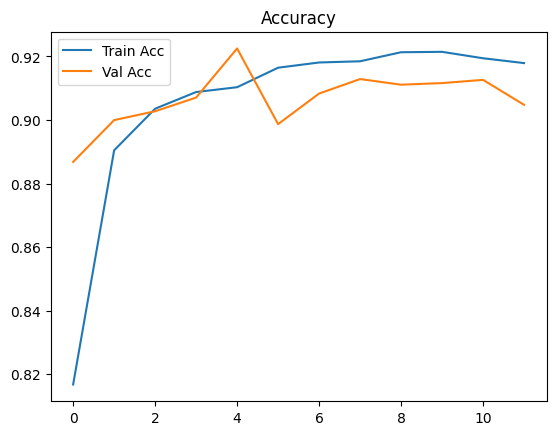

In [7]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

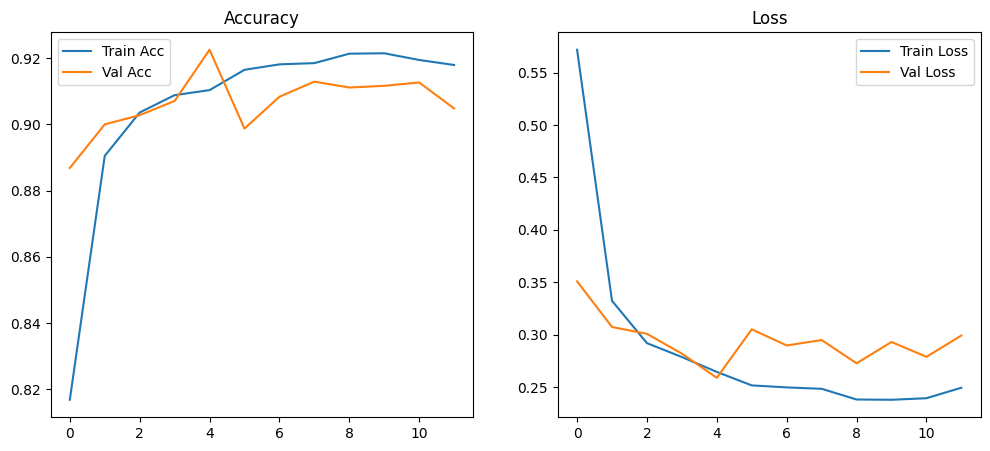

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [9]:
model.save("trash_classifier1.2.h5")

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


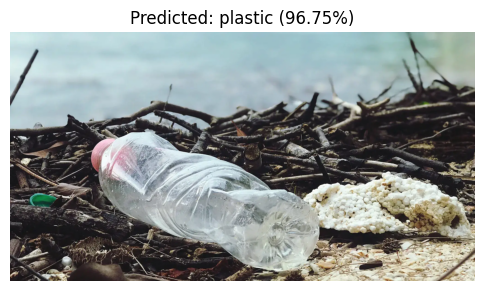

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


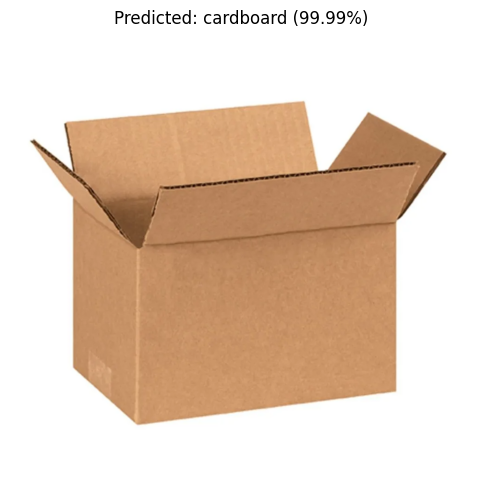

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


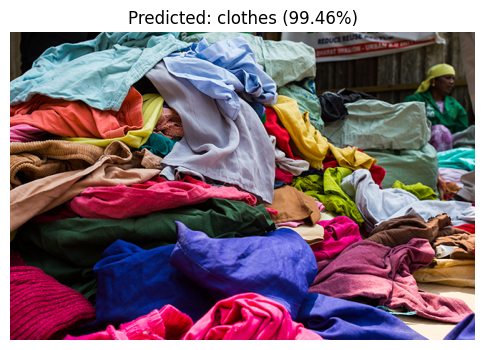

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


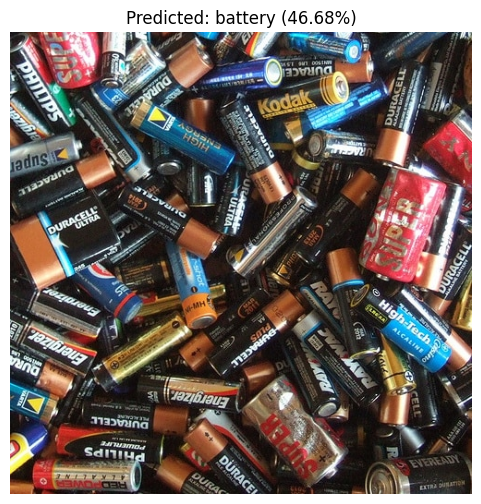

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


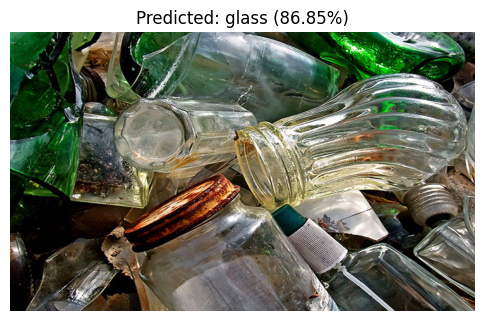

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


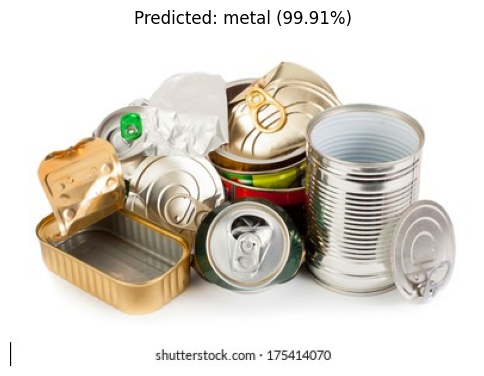

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


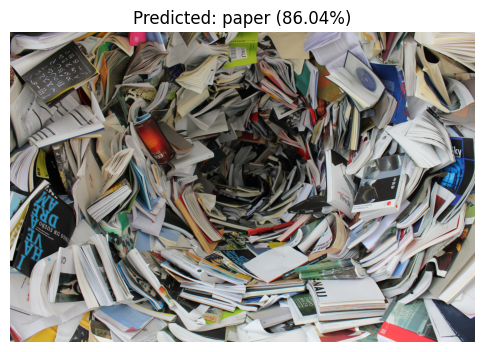

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


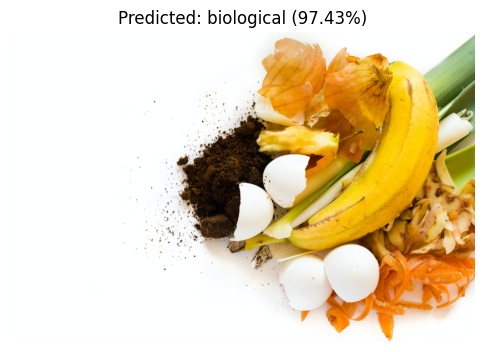

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


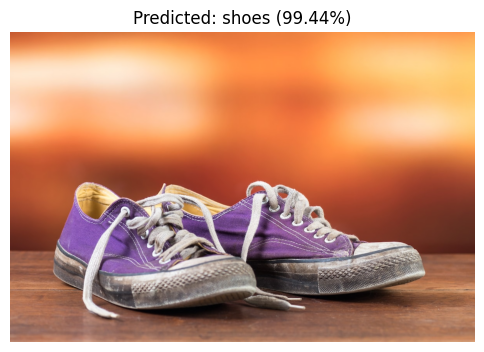

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


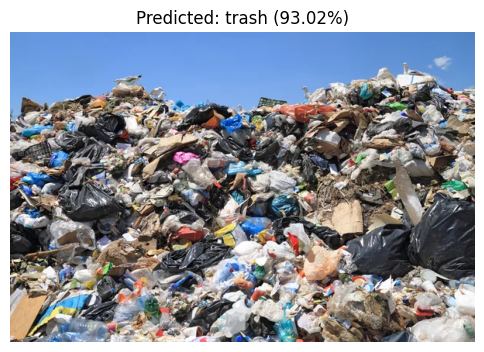

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Define class names
CLASS_NAMES = ['battery', 'biological', 'cardboard', 'clothes', 'glass',
               'metal', 'paper', 'plastic', 'shoes', 'trash']

# Load your model
model_path = '/kaggle/input/trash-and-waste-recognation/tensorflow2/1.2/1/trash_classifier1.2.h5'
model = load_model(model_path)

# List of image URLs
image_urls = [
    "https://www.officeh2o.com/wp-content/uploads/2020/02/why-are-disposable-water-bottles-harmful-to-the-environment.webp",
    "https://itppackaging.com/wp-content/uploads/2021/02/box.jpg",
    "https://www.intellecap.com/wp-content/uploads/2024/05/new_case_study02.jpg",
    "https://sustainingourworld.com/wp-content/uploads/2014/09/Dead-batteries.jpg",
    "https://tipitrubbishremoval.com.au/wp-content/uploads/2022/06/glass-recycling-why-you-shouldnt-throw-glass-rubbish-in-the-bin-1.jpeg",
    "https://www.shutterstock.com/image-photo/empty-metal-cans-waiting-on-260nw-175414070.jpg",
    "https://cdn.prod.website-files.com/6076eb6f757c580e3cd74f70/65e73f3864826dcd7ada8953_pexels-pixabay-159751.jpg",
    "https://www.nycfoodpolicy.org/wp-content/uploads/2020/02/shutterstock_619780853.png",
    "https://wastemanagementreview.com.au/wp-content/uploads/2022/08/old-shoes.jpeg",
    "https://st.depositphotos.com/1005914/2556/i/450/depositphotos_25567715-stock-photo-garbage-and-seagulls.jpg"
    
    
]

# Define target image size
img_size = (224, 224)

# Process and predict each image
for image_url in image_urls:
    try:
        # Load image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        # Resize and preprocess the image
        resized_img = img.resize(img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(resized_img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Predict
        predictions = model.predict(img_array)
        predicted_class = CLASS_NAMES[np.argmax(predictions)]
        confidence = np.max(predictions)

        # Display image with prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print(f"Failed to process {image_url}: {e}")
